In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg 
import scipy
import pandas as pd
import copy
import seaborn as sns

In [2]:
def RCA(Xcp):
    """
    Xcp is a numpy.matrix type
    --|steel|oil|chip|bean|clothes
    --|--|--|--|--|--
    USA|1|1|1|1|0
    China|1|0|0|1|1
    Viet Nam|0|0|0|1|1
    """
    if type(Xcp) is not np.matrix:
        if type(Xcp) is np.array or list:
            Xcp = np.matrix(Xcp)
        else:
            raise ValueError('Xcp must be matrix')
    else:
        pass
    B = Xcp.sum(1)*Xcp.sum(0) 
    Sum = Xcp.sum()
    return Xcp*Sum/B
    
def fliterRCA(R):
    M = R>1
    return M.astype(float)


def Get_eci_pci(M):
    D = np.diag(M.sum(1).T.tolist()[0])
    U = np.diag(M.sum(0).tolist()[0])
    mcp1 = np.linalg.inv(D) * M
    mcp2 = M * np.linalg.inv(U)
    Mcc = mcp1 * mcp2.T
    Mpp = mcp2.T * mcp1
    eigvals, eigvecs = np.linalg.eig(Mpp)
    eigvecs = np.real(eigvecs)
    # Get eigenvector corresponding to second largest eigenvalue
    eig_index = eigvals.argsort()[-2]
    kp = eigvecs[:, eig_index]
    kc = mcp1 * kp
    s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
    eci = s1 * kc
    pci = s1 * kp  
    return eci,pci
def Get_eci_pci_sparse(M):
    d = M.sum(1).T.tolist()[0]
    u = M.sum(0).tolist()[0]
    nd,nu = len(d),len(u)
    D = scipy.sparse.csc_matrix((d, (range(nd), range(nd))),shape=(nd,nd))
    U = scipy.sparse.csc_matrix((u, (range(nu), range(nu))),shape=(nu,nu))
    D1=scipy.sparse.linalg.inv(D)
    U1=scipy.sparse.linalg.inv(U)
    M = sparse.csc_matrix(M)
    mcp1 = D1 * M
    mcp2 = M * U1
    Mcc = mcp1 * mcp2.T
    Mpp = mcp2.T * mcp1
    A=scipy.sparse.csc_matrix(Mpp)
    eigvals, eigvecs = scipy.sparse.linalg.eigs(A, k=2)
    eigvecs = np.real(eigvecs)
    # Get eigenvector corresponding to second largest eigenvalue
    eig_index = eigvals.argsort()[-2]
    kp = eigvecs[:, eig_index]
    kc = mcp1 @ kp
    s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
    eci = s1 * kc
    pci = s1 * kp
    return eci,pci

def Get_z_score(x):
    x=np.array(x)
    std=np.std(x)
    mean=np.mean(x)
    return (x-std)/mean

# example

--|steel|oil|chip|bean|clothes
--|--|--|--|--|--
USA|1|1|1|1|0
China|1|0|0|1|1
Viet Nam|0|0|0|1|1

In [293]:
# example data
product_name = ["steel","oil","chip","bean","clothes"]
country_name = ["USA","China","Viet Nam"]
data = [[1,1,1,1,0],[1,0,0,1,1],[0,0,0,1,1]]
data = np.matrix(data)
R = RCA(data)
M = fliterRCA(R)
D = np.diag(M.sum(1).T.tolist()[0])
U = np.diag(M.sum(0).tolist()[0])
mcp1 = np.linalg.inv(D) * M
mcp2 = M * np.linalg.inv(U)
Mcc = mcp1 * mcp2.T
Mpp = mcp2.T * mcp1
A=scipy.sparse.csc_matrix(Mpp)
eigvals, eigvecs = scipy.sparse.linalg.eigs(A, k=2)
eigvecs = np.real(eigvecs)
# Get eigenvector corresponding to second largest eigenvalue
eig_index = eigvals.argsort()[-2]
kp = eigvecs[:, eig_index]
kc = mcp1 @ kp
s1 = np.sign(np.corrcoef(M.sum(1).reshape(-1), kc.reshape(-1))[0, 1])
eci = s1 * kc
pci = s1 * kp
print(country_name)
print(eci.tolist()[0])
print('='*50)
print(product_name)
print(pci)

['USA', 'China', 'Viet Nam']
[0.3823002058917103, -0.08766501837964581, -0.48578529045792046]
['steel', 'oil', 'chip', 'bean', 'clothes']
[ 0.18527832  0.48081115  0.48081115 -0.61096222 -0.36060836]


# test on PNAS_workerdataframe_v4.pkl

In [2]:
wd1= pd.read_pickle('./PNAS_workerdataframe_v4.pkl')
wd=wd1.dropna(subset=['log_realized_wage','log_requested_wage'])

In [3]:
rqw,rlw=wd['log_requested_wage'],wd['log_realized_wage']

/home/liujing/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(32.125,0.5,'log_realized_wage')

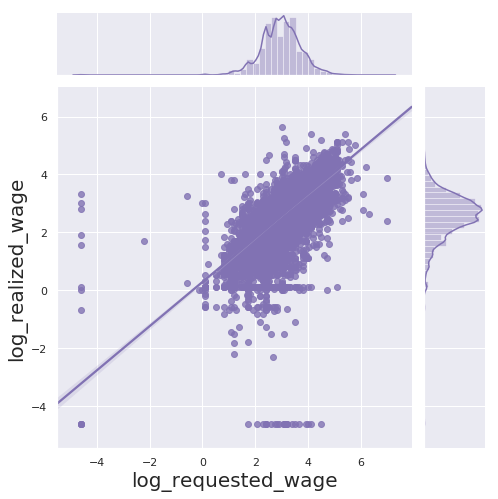

In [5]:
sns.set(style="darkgrid")
tips = sns.load_dataset("tips")
g = sns.jointplot("log_requested_wage", "log_realized_wage", data=wd, kind="reg",color="m", height=7)
plt.xlabel("log_requested_wage",fontsize=20)
plt.ylabel("log_realized_wage",fontsize=20)

In [6]:
#skills-one-hot-codeing
lst=[]
for skills in wd['skills']:
    lst+=skills
lst=list(set(lst))
skill_id=dict(zip(lst,range(len(lst))))
id_skill=dict(zip(range(len(lst)),lst))
data_skill=[[skill_id[s] for s in  p_skills]  for p_skills  in wd['skills']]

In [7]:
from scipy import sparse
row = []
col = []
for i in range(len(data_skill)):
    row += [i for dj in data_skill[i]]
    col += [dj for dj in data_skill[i]]
data_value = [1] * len(row)
m,n = max(row)+1,max(col)+1
c = sparse.csc_matrix((data_value,(row,col)),shape=(m,n))
c = c.toarray()

In [8]:
# R = RCA(c)
# M = fliterRCA(R)
c=np.matrix(c)

([<matplotlib.axis.XTick at 0x7f8f19a4b4e0>,
 <a list of 6 Text xticklabel objects>)

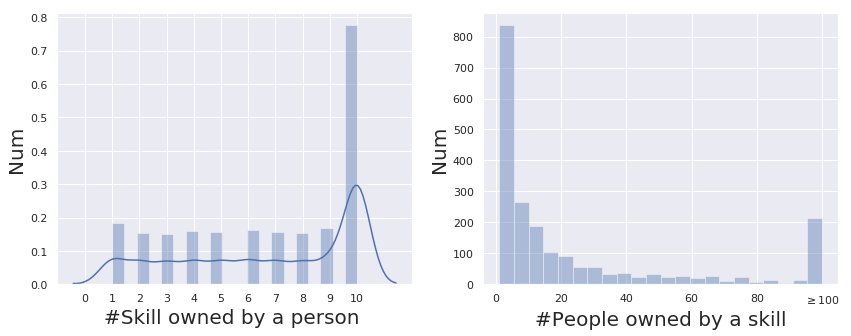

In [346]:
plt.figure(figsize=(14,5))
plt.subplot(121)
sns.distplot([len(s) for s in data_skill],kde=True)
plt.ylabel('Num',fontsize=20)
plt.xlabel('#Skill owned by a person ',fontsize=20)
plt.xticks(range(11))
plt.subplot(122)
sns.distplot([i if i<100 else 100for i in c.sum(0)],kde=False)
#plt.yscale('log')
p20=sum([1 if i<20 else 0 for i in c.sum(0)])/len(c.sum(0))
p40=sum([1 if i<40 else 0 for i in c.sum(0)])/len(c.sum(0))
plt.ylabel('Num',fontsize=20)
plt.xlabel('#People owned by a skill',fontsize=20)
plt.xticks(range(0,101,20),[str(i) if i<100 else "$\geq100$" for i in range(0,101,20)])
#plt.title("distribution of Skill",fontsize=20)

# 超过70%的人掌握10个技能
# 大部分的技能仅有不到5个人掌握
# 超过100人掌握的技能有200个

In [9]:
eci,pci = Get_eci_pci_sparse(np.matrix(c))

Text(0.5,0,'eci')

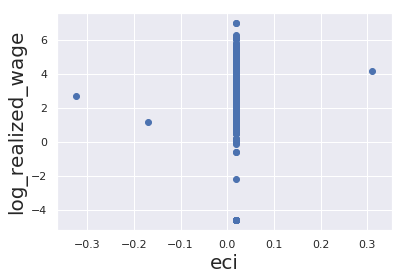

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter(eci.tolist(),rqw)
plt.ylabel("log_realized_wage",fontsize=20)
plt.xlabel("eci",fontsize=20)

# 利用ecomplexity 包来处理数据


In [4]:
#skills-one-hot-codeing
from collections import Counter
mylst = []
for skills in wd['skills']:
    mylst += skills
NumD = dict(Counter(mylst))
limit_num=2
Remove = [sk for sk in NumD if NumD[sk]<limit_num]# remove skills that appear less than 3 times
Remain = [sk for sk in NumD if NumD[sk]>=limit_num]
print("#Total",len(NumD))
print("#Remove",len(Remove))
print("#Remain",len(Remain))
skills_new=[[sk for sk in tmp if sk not in Remove] for tmp in wd['skills']]

#Total 2116
#Remove 281
#Remain 1835


In [5]:
#构建原始数据
from ecomplexity import ecomplexity
from ecomplexity import proximity
# Calculate complexity
trade_cols = {'time':'year', 'loc':'name', 'prod':'skill', 'val':'value'}
Name=[]
Skill=[]
time=[]
value=[]
for ind,sks in zip(wd.index,skills_new):
    for sk in sks:
        Name.append(ind)
        Skill.append(sk)
time=[2019]*len(Name)    
value=[1.]*len(Name)   


In [6]:
SData=pd.DataFrame({"year":time,'name':Name,"skill":Skill,"value":value})

In [7]:
trade_cols={'time':'year', 'loc':'name', 'prod':'skill', 'val':'value'}

In [8]:
cdata = ecomplexity(SData, trade_cols)

2019


In [14]:
cdata

,name,skill,value,year,diversity,ubiquity,mcp,eci,pci,density,coi,cog,rca
0,~01000198dad8ee8b76,.net-compact-framework,0.0,2019,10,8,0,0.229361,1.590111,0.000549,0.014165,1.234934,0.000000
1,~01000198dad8ee8b76,.net-framework,0.0,2019,10,705,0,0.229361,1.466682,0.022746,0.014165,1.465018,0.000000
2,~01000198dad8ee8b76,.net-remoting,0.0,2019,10,3,0,0.229361,1.646412,0.000257,0.014165,1.328108,0.000000
3,~01000198dad8ee8b76,1shoppingcart,0.0,2019,10,7,0,0.229361,0.578429,0.008025,0.014165,0.352657,0.000000
4,~01000198dad8ee8b76,2d-animation,0.0,2019,10,164,0,0.229361,-0.280877,0.020002,0.014165,-0.506047,0.000000
5,~01000198dad8ee8b76,2d-design,0.0,2019,10,68,0,0.229361,-0.248759,0.014191,0.014165,-0.497185,0.000000
6,~01000198dad8ee8b76,3d-animation,0.0,2019,10,167,0,0.229361,-0.272977,0.014431,0.014165,-0.498737,0.000000
7,~01000198dad8ee8b76,3d-design,0.0,2019,10,193,0,0.229361,-0.170939,0.018273,0.014165,-0.460797,0.000000
8,~01000198dad8ee8b76,3d-modeling,0.0,2019,10,281,0,0.229361,-0.236966,0.019306,0.014165,-0.489887,0.000000
9,~01000198dad8ee8b76,3d-printing,0.0,2019,10,22,0,0.229361,-0.280332,0.001950,0.014165,-0.428716,0.000000


In [10]:
prox_df = proximity(SData, trade_cols)

2019


In [12]:
import pickle
with open('cdata.pkl','wb') as f:
    pickle.dump({"cdata":cdata,"prox_df":prox_df},f)

In [18]:
33483245/1835

18247.0

In [22]:
cdata.loc[1835]

name            ~010004a03173568fbf
skill        .net-compact-framework
value                             0
year                           2019
diversity                         9
ubiquity                          8
mcp                               0
eci                         1.42759
pci                         1.59011
density                  0.00177742
coi                         1.74421
cog                         1.23451
rca                               0
Name: 1835, dtype: object

In [46]:
# 提取信息
ECI={}
PCI={}
density={}
cog={}
for ik in range(1835):
    i=18247*ik
    name=cdata.loc[i]["name"]
    sk = cdata.loc[i]["skill"]  
    if name not in ECI:
        ECI[name]=cdata.loc[i]["eci"]
    if name not in density:
        density[name]=cdata.loc[i]["density"]
        
for i in range(1835):
    name=cdata.loc[i]["name"]
    sk = cdata.loc[i]["skill"]  
    if sk not in PCI:
        PCI[sk]=cdata.loc[i]["pci"]
    if sk not in density:
        cog[sk]=cdata.loc[i]["cog"]

In [47]:
with open('cdata_res.pkl','wb') as f:
    pickle.dump({"ECI":ECI,"PCI":PCI,"density":density,"cog":cog},f)

In [31]:
#rqw,rlw
namelist=[name for name in ECI]
wage_rq=[rqw[name] for name in namelist]
wage_rl=[rlw[name] for name in namelist]
x_eci=[ECI[name] for name in namelist]
x_den=[density[name] for name in namelist]

#x_cog=[cog[name] for name in namelist]
#x_pci=[PCI[name] for name in namelist]


/home/liujing/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(-1,-4,'Pearsonr=0.220')

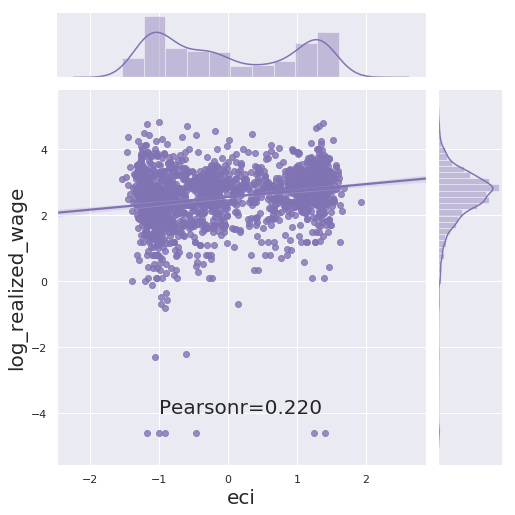

In [53]:
from scipy.stats import pearsonr
sns.set(style="darkgrid")
tips = sns.load_dataset("tips")
g = sns.jointplot(x_eci,wage_rl, kind="reg",color="m", height=7)
plt.xlabel("eci",fontsize=20)
plt.ylabel("log_realized_wage",fontsize=20)
p,pp=pearsonr(x_eci,wage_rl)
plt.text(-1,-4,"Pearsonr=%.3f"%p,fontsize=20)

/home/liujing/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(-1,-2,'Pearsonr=0.254')

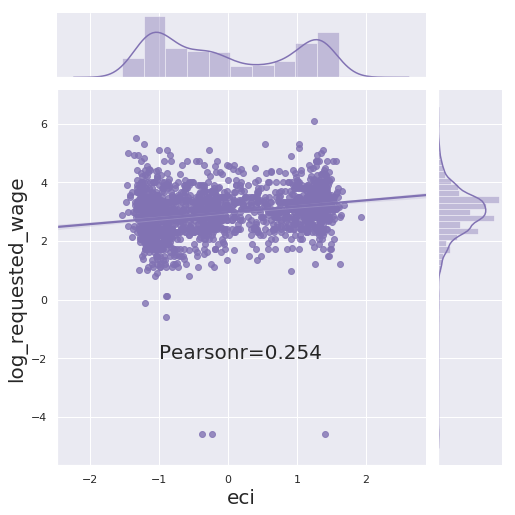

In [52]:
sns.set(style="darkgrid")
tips = sns.load_dataset("tips")
g = sns.jointplot(x_eci,wage_rq, kind="reg",color="m", height=7)
plt.xlabel("eci",fontsize=20)
plt.ylabel("log_requested_wage",fontsize=20)
p,pp=pearsonr(x_eci,wage_rq)
plt.text(-1,-2,"Pearsonr=%.3f"%p,fontsize=20)

In [49]:
#统计不同技能的平均收益
Wage_skill_rq={}
Wage_skill_rl={}
for ind,sks in zip(wd.index,skills_new):
    for sk in sks:
        if sk not in Wage_skill_rq:
            Wage_skill_rq[sk]=[]
            Wage_skill_rl[sk]=[]
        Wage_skill_rq[sk].append(wd.loc[ind]["log_requested_wage"])
        Wage_skill_rl[sk].append(wd.loc[ind]["log_realized_wage"])

In [54]:
evg_sk_rq={}
evg_sk_rl={}
for sk in Wage_skill_rq:
    evg_sk_rq[sk]=np.mean(Wage_skill_rq[sk])
    evg_sk_rl[sk]=np.mean(Wage_skill_rl[sk])

In [56]:
x_cog=[cog[sk] for sk in Remain]
x_pci=[PCI[sk] for sk in Remain]


In [57]:
y_evg_sk_rq=[evg_sk_rq[sk] for sk in Remain]
y_evg_sk_rl=[evg_sk_rl[sk] for sk in Remain]

/home/liujing/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(-1,0,'Pearsonr=0.424')

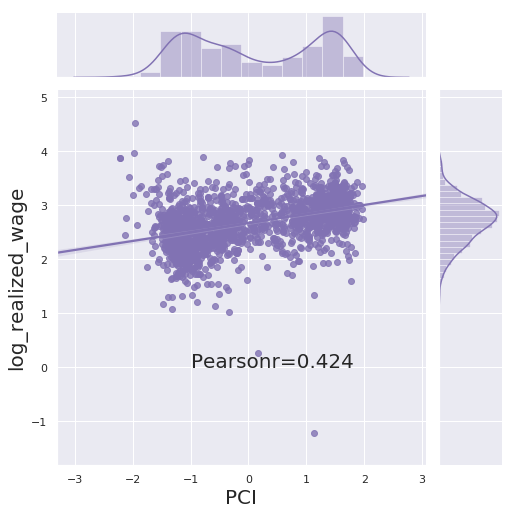

In [61]:
sns.set(style="darkgrid")
tips = sns.load_dataset("tips")
g = sns.jointplot(x_pci,y_evg_sk_rl, kind="reg",color="m", height=7)
plt.xlabel("PCI",fontsize=20)
plt.ylabel("log_realized_wage",fontsize=20)
p,pp=pearsonr(x_pci,y_evg_sk_rl)
plt.text(-1,0,"Pearsonr=%.3f"%p,fontsize=20)

/home/liujing/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(-1,1.5,'Pearsonr=0.441')

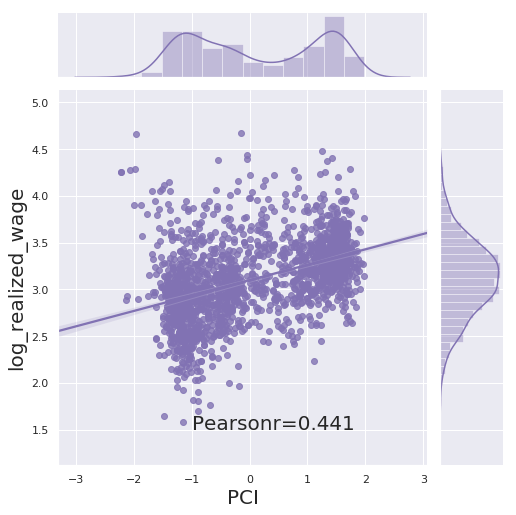

In [62]:
sns.set(style="darkgrid")
tips = sns.load_dataset("tips")
g = sns.jointplot(x_pci,y_evg_sk_rq, kind="reg",color="m", height=7)
plt.xlabel("PCI",fontsize=20)
plt.ylabel("log_realized_wage",fontsize=20)
p,pp=pearsonr(x_pci,y_evg_sk_rq)
plt.text(-1,1.5,"Pearsonr=%.3f"%p,fontsize=20)